# Sensitivity Curve: ASD(f; L, Λ)
在一张图中用 **线型** 表示臂长 L，用 **线宽** 表示激光波长 Λ。
公式来自 LISA/Taiji/TianQin 常见经验形式（参照 1803.01944），并可按需替换。

In [1]:

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# 频率轴
fmin, fmax = 1e-4, 1.0  # Hz
f = np.logspace(np.log10(fmin), np.log10(fmax), 1800)

# 常量
pi = np.pi
c  = 299792458.0  # m/s

def PSD_L_lambda(f, L, Lambda_nm, coeff=(0.0, (1.5e-11)**2)):
    """From https://arxiv.org/pdf/1803.01944.pdf."""
    f = np.asarray(f, dtype=float)
    f = np.where(f <= 0, np.finfo(float).tiny, f)
    f0 = c / (2 * pi * L)

    # 备选（未直接使用，便于切换任务假设）
    Poms_LISA    = (1.5e-11)**2
    Poms_Tianqin = (1.0e-12)**2
    Poms_Taiji   = (8.0e-12)**2

    a, b = coeff
    Poms = (a * L * L + b) * (1.0 + (2e-3 / f)**4) * (Lambda_nm / 1000.0)
    Pacc = (3e-15)**2 * (1.0 + (4e-3 / (10.0 * f))**2) * (1.0 + (f / (8e-3))**4) * (1000.0 / Lambda_nm)**2
    Sc   = 9e-45 * f**(-7.0/3.0) * np.exp(-f**0.171 + 292.0*f*np.sin(1020.0*f)) * (1.0 + np.tanh(1680.0*(0.00215 - f)))

    PSD = (10.0 / (3.0 * L * L)) * (Poms + (4.0 * Pacc) / ((2 * pi * f)**4)) * (1.0 + 0.6 * (f / f0)**2) + Sc
    PSD = np.where(~np.isfinite(PSD), np.nan, PSD)
    PSD = np.where(PSD <= 0, np.nan, PSD)
    return PSD


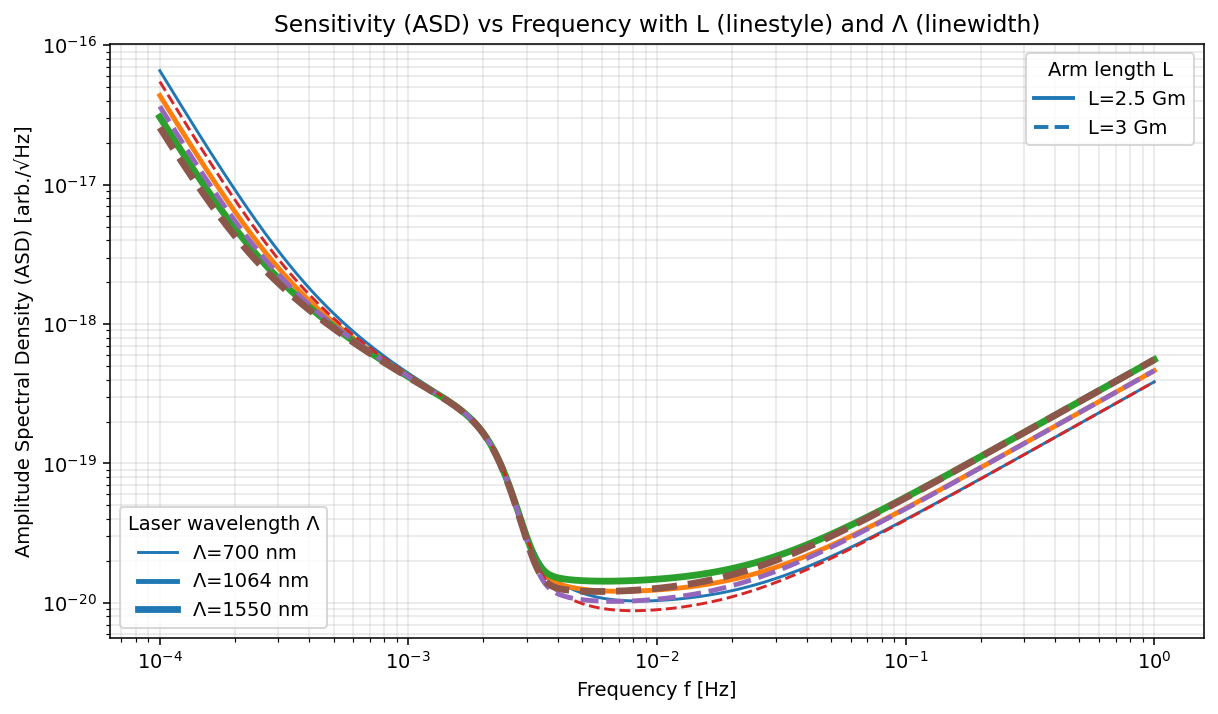

In [2]:

# 参数网格（线型 -> L；线宽 -> Λ）
L_list_m       = [ 2.5e9, 3.0e9]      # 0.17/1/3 Gm
Lambda_list_nm = [700.0, 1064.0, 1550.0]     # nm
linestyles = ['-', '--', '-.']
linewidths = [1.5, 2.5, 3.5]

plt.figure(figsize=(8.8, 5.2), dpi=140)
ax = plt.gca()

for iL, L in enumerate(L_list_m):
    ls = linestyles[iL % len(linestyles)]
    for jLam, Lam in enumerate(Lambda_list_nm):
        lw = linewidths[jLam % len(linewidths)]
        PSD = PSD_L_lambda(f, L=L, Lambda_nm=Lam, coeff=(0.0, (1.5e-11)**2))
        ASD = np.sqrt(PSD)
        ax.loglog(f, ASD, linestyle=ls, linewidth=lw, label=f"L={L/1e9:g} Gm, Λ={Lam:g} nm")

ax.set_xlabel("Frequency f [Hz]")
ax.set_ylabel("Amplitude Spectral Density (ASD) [arb./√Hz]")
ax.set_title("Sensitivity (ASD) vs Frequency with L (linestyle) and Λ (linewidth)")
ax.grid(True, which="both", alpha=0.3)

legend_L = [Line2D([0], [0], linestyle=linestyles[i], linewidth=2) for i in range(len(L_list_m))]
labels_L = [f"L={L/1e9:g} Gm" for L in L_list_m]
leg1 = ax.legend(legend_L, labels_L, title="Arm length L", loc="upper right")

legend_Lambda = [Line2D([0], [0], linestyle='-', linewidth=linewidths[j]) for j in range(len(Lambda_list_nm))]
labels_Lambda = [f"Λ={Lam:g} nm" for Lam in Lambda_list_nm]
leg2 = ax.legend(legend_Lambda, labels_Lambda, title="Laser wavelength Λ", loc="lower left")
ax.add_artist(leg1)

plt.tight_layout()
plt.show()
